# Object Detection

Name: Krunal Shah </br>
Student ID: 13803566

# Object Detection

In this notebook, object detection techniques such as Faster RCNN and SSD is performed on Red Blood Cell (RBC) Dataset. The RBC dataset contains 348 images along with their annotations.The image size (640,480) pixel. The main purpose of the dataset is to detect the red blood cell in the images.

There are few images in the dataset which are not annotat. So I have used [this tool](https://www.makesense.ai/) for image annotations. I have used almost 90% of the dataset for training 8% for validation and 2% for testing.

This is the link of my git repository. [Click here](https://github.com/Krunal18/object_detection_demo)

In [7]:
%tensorflow_version 1.x

# Faster RCNN

I have imported regular expression library for modification of the configuration file of faster RCNN. Below I have put some experimental settings like training steps and number of evaluation step 30,000 and 50 respectively. Also the batch size is set to 12. 

In [8]:
import os
import re
import shutil
import glob
import urllib.request
import tarfile

repo_url = 'https://github.com/Krunal18/object_detection_demo'


num_steps = 30000 #Training steps.

num_eval_steps = 50 # Evaluation step

MODELS_CONFIG = {
   'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    }
}

MODEL = MODELS_CONFIG["faster_rcnn_inception_v2"]['model_name']

pipeline_file = MODELS_CONFIG["faster_rcnn_inception_v2"]['pipeline_file']

batch_size = MODELS_CONFIG["faster_rcnn_inception_v2"]['batch_size']

Now I am going to clone my repository from the provided url. In that there is dataset is also there.Once the execution has been started, it will pull the folders and files from GitHub, and you'll see the folder created into the drive under the name of "object_detection_demo".

In [5]:
%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 807, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 807 (delta 26), reused 0 (delta 0), pack-reused 759
Receiving objects: 100% (807/807), 6.61 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/object_detection_demo
Already up to date.


For object detection, I have used google API and some other dependencies. The code will clone the model which contains pipeline for faster RCNN

In [6]:
%cd /content
# Clone repo
!git clone --quiet https://github.com/tensorflow/models.git

%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
%cp object_detection/packages/tf1/setup.py .
!/usr/bin/python3 -m pip install .

# Test the installation.
!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
cp: cannot stat 'object_detection/packages/tf1/setup.py': No such file or directory
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=801478 sha256=01f8037e3cf4f39041eb366b61619049c5df978200b95dd797b1f7119f9e6039
  Stored in directory: /tmp/pip-ephem-wheel-cache-1q6y8q73/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] Mode

The next step is to convert the dataset to tf records. First we will convert the xml into csv files and label map files. Then we will convert the csv files, images and label map files into tfrecords. 

In [ ]:
%cd {repo_dir_path}

!python xml_to_csv.py -i RBC_dataset/Images/Train -o RBC_dataset/annotations/train_labels.csv -l RBC_dataset/annotations

!python xml_to_csv.py -i RBC_dataset/Images/Test -o RBC_dataset/annotations/test_labels.csv

!python generate_tfrecord.py --csv_input=RBC_dataset/annotations/train_labels.csv --output_path=RBC_dataset/annotations/train.record --img_path=RBC_dataset/Images/Train --label_map RBC_dataset/annotations/label_map.pbtxt

!python generate_tfrecord.py --csv_input=RBC_dataset/annotations/test_labels.csv --output_path=RBC_dataset/annotations/test.record --img_path=RBC_dataset/Images/Test --label_map RBC_dataset/annotations/label_map.pbtxt


test_record_fname = '/content/object_detection_demo/RBC_dataset/annotations/test.record'
train_record_fname = '/content/object_detection_demo/RBC_dataset/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/RBC_dataset/annotations/label_map.pbtxt'

/content/object_detection_demo
Successfully converted xml to csv.
Generate `RBC_dataset/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0519 13:48:31.174440 140469183240064 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0519 13:48:31.240065 140469183240064 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/RBC_dataset/annotations/train.record


W0519 13:48:33.885348 140430756943744 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0519 13:48:33.899840 140430756943744 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFR

Now I will use transfer learning to train my model. I will use Faster RCNN pre-trained model to finetune my model. The baseline Faster RCNN model will be download, and then I will use that model to train my model. The below code will download the model. It will contain checkpoint, frozen graph and the configuration file.

In [ ]:
%cd /content/models/research

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 23 root   root 4.0K May 19 13:48 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


The below code contain the checkpoint of the pre-trained model

In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

Next step I will customize the configuration file. The reason for doing this is because to make the configuration according to our dataset.

In [ ]:
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

The below code will configure the Faster RCNN configuration file according to our dataset. The path for checkpoint, train, test, batch size and classes.

In [ ]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

Below there is configration file. The total number of classes are 1 (RBC), the batch size is 16. The number of steps are set to 30000.The learning rate is 0.000002. The detail information is shown below.

In [ ]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

**I will use the tensor board for our visualization. The below series of codes will give us a link to the tensor board, which will connect to our training model.**

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-05-19 13:49:26--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.209.238.187, 34.193.189.47, 34.207.48.100, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.209.238.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  14.0MB/s    in 0.9s    

2021-05-19 13:49:27 (14.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')


In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    

http://58ef423a9477.ngrok.io


# Model Training

This evaluation is the representation of Coco. The different IoU repsent the threasholad from 0.5 to 0.95 with the model taking the 10 best parameters. The small, medium and large represent the detection of bouding boxs on the smaller, medium and large object in the image. The model IoU is accurate for medium to large objects.

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0519 14:46:29.711488 140413158348672 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 30000
I0519 14:46:29.711726 140413158348672 config_util.py:552] Maybe overwriting train_steps: 30000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0519 14:46:29.711814 140413158348672 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0519 14:46:29.711878 140413158348672 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0519 14:46:29.711943 140413158348672 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0519 14:46:29.712038 140413158348672 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

The below code will take the last checkpoint and will create a graph file. I have used the graph file to do inference on test images. The test folder has 2% of the dataset from the whole dataset

In [ ]:
import re
import numpy as np
import os
output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-30000
Instructions for updating:
Please use `layer.__call__` method instead.
W0519 19:01:48.972234 139844883429248 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0519 19:01:50.417763 139844883429248 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0519 19:01:50.556033 139844883429248 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0519 19:01:50.556495 139844883429248 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0519 19:01:50.617014

In [ ]:
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 50M May 19 19:01 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


# Model Testing

In [ ]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/object_detection_demo/", "Testing")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/Testing/BloodImage_00004.jpeg', '/content/object_detection_demo/Testing/BloodImage_00002.jpeg', '/content/object_detection_demo/Testing/BloodImage_00001.jpeg', '/content/object_detection_demo/Testing/BloodImage_00003.jpeg', '/content/object_detection_demo/Testing/BloodImage_00000.jpeg']


The below cell will show the object detection one by one from the test image and also print the accuracy on that.

/content/models/research/object_detection


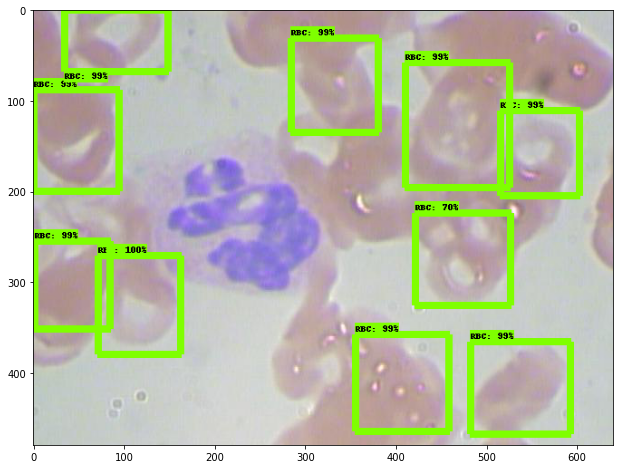

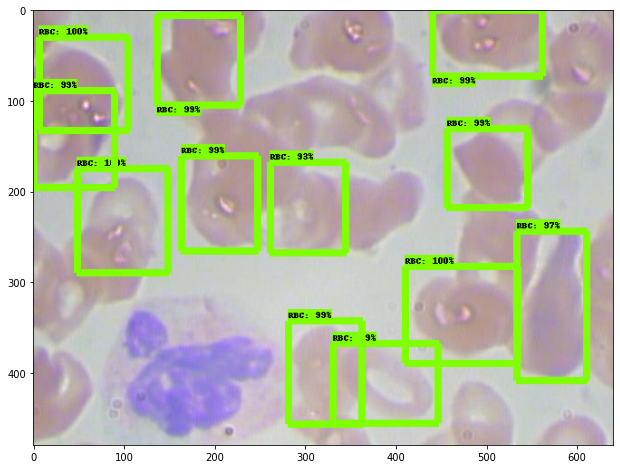

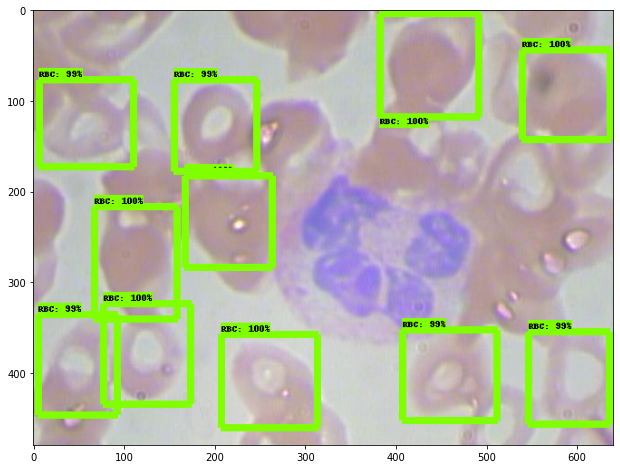

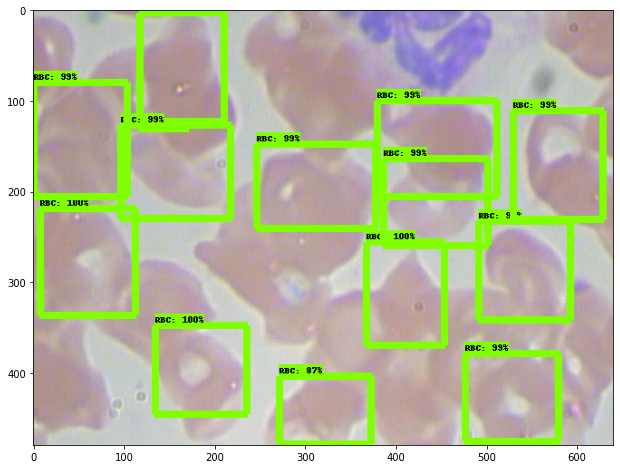

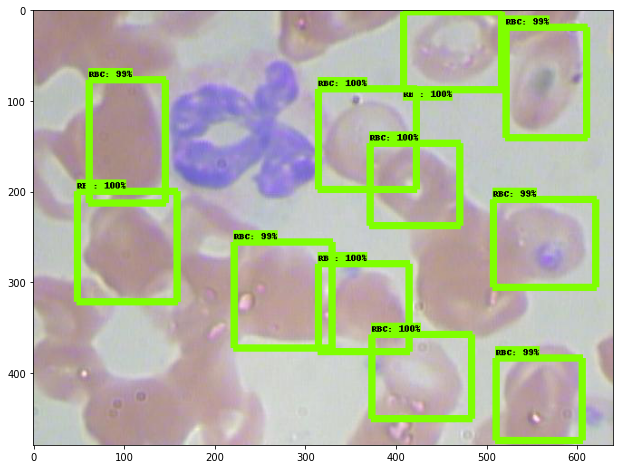

In [34]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# Single Shot Detector (SSD)



In [9]:
%tensorflow_version 1.x

For SSD I have put 85,000 training steps and 50 evaluation steps. I have put more steps oer here is just because is SSD is faster then Faster RCNN in terms of speed.

As I earlier mentioned that I am going to use SSD mobilenet v2 model. It has 12 batch size.

In [10]:
import os
import re
import shutil
import glob
import urllib.request
import tarfile

repo_url = 'https://github.com/Krunal18/object_detection_demo'

#Training steps.
num_steps = 85000

#Evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
   
   'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    }
}

MODEL = MODELS_CONFIG["ssd_mobilenet_v2"]['model_name']

pipeline_file = MODELS_CONFIG["ssd_mobilenet_v2"]['pipeline_file']

batch_size = MODELS_CONFIG["ssd_mobilenet_v2"]['batch_size']

Other steps are same as I have performed above in faster RCNN.

In [11]:
%cd /content


!git clone --branch r1.13.0 --depth 1 https://github.com/tensorflow/models.git


!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

# To check everything is runing as per req
!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_embedded_ssd_mobilenet_v1_model_from_config
[       OK ] ModelBuilderTest.test_create_embedded_ssd_mobilenet_v1_model_from_config
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
Instructions for updating:
Use `tf.cast` instead.
W0520 00:59:14.123514 140550755088256 deprecation.py:323] From /content/models/research/object_detection/anchor_generators/grid_anchor_generator.py:59: to_

In [12]:
%cd {repo_dir_path}

!python xml_to_csv.py -i RBC_dataset/Images/Train -o RBC_dataset/annotations/train_labels.csv -l RBC_dataset/annotations

!python xml_to_csv.py -i RBC_dataset/Images/Test -o RBC_dataset/annotations/test_labels.csv

!python generate_tfrecord.py --csv_input=RBC_dataset/annotations/train_labels.csv --output_path=RBC_dataset/annotations/train.record --img_path=RBC_dataset/Images/Train --label_map RBC_dataset/annotations/label_map.pbtxt

!python generate_tfrecord.py --csv_input=RBC_dataset/annotations/test_labels.csv --output_path=RBC_dataset/annotations/test.record --img_path=RBC_dataset/Images/Test --label_map RBC_dataset/annotations/label_map.pbtxt


test_record_fname = '/content/object_detection_demo/RBC_dataset/annotations/test.record'
train_record_fname = '/content/object_detection_demo/RBC_dataset/annotations/train.record'
label_map_pbtxt_fname = '/content/object_detection_demo/RBC_dataset/annotations/label_map.pbtxt'

/content/object_detection_demo
Successfully converted xml to csv.
Generate `RBC_dataset/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0520 00:59:20.786655 140190929201024 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0520 00:59:20.796921 140190929201024 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/object_detection_demo/RBC_dataset/annotations/train.record


W0520 00:59:23.157540 139984491796352 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0520 00:59:23.163048 139984491796352 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gf

In [13]:
%cd /content/models/research

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [14]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 70 root   root  4.0K May 20 00:59 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [15]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

In [16]:
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [17]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

# Configure model

Below I have configured the SSD model.

In [18]:
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [19]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [20]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [21]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-05-20 00:59:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.175.245.12, 3.209.27.98, 54.159.163.191, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.175.245.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  18.4MB/s    in 0.7s    

2021-05-20 00:59:58 (18.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [22]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [23]:
get_ipython().system_raw('./ngrok http 6006 &')


In [24]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://7d20c26c9f42.ngrok.io


# Training SDD Model with RBC dataset

In [25]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
I0520 01:25:19.521481 139894324426624 basic_session_run_hooks.py:260] loss = 2.9358017, step = 8500 (16.845 sec)
INFO:tensorflow:global_step/sec: 5.91118
I0520 01:25:36.437639 139894324426624 basic_session_run_hooks.py:692] global_step/sec: 5.91118
INFO:tensorflow:loss = 3.7632577, step = 8600 (16.917 sec)
I0520 01:25:36.438534 139894324426624 basic_session_run_hooks.py:260] loss = 3.7632577, step = 8600 (16.917 sec)
INFO:tensorflow:global_step/sec: 5.9179
I0520 01:25:53.335503 139894324426624 basic_session_run_hooks.py:692] global_step/sec: 5.9179
INFO:tensorflow:loss = 2.848872, step = 8700 (16.898 sec)
I0520 01:25:53.336352 139894324426624 basic_session_run_hooks.py:260] loss = 2.848872, step = 8700 (16.898 sec)
INFO:tensorflow:global_step/sec: 5.92606
I0520 01:26:10.210101 139894324426624 basic_session_run_hooks.py:692] global_step/sec: 5.92606
INFO:tensorflow:loss = 2.5888922, step = 8800 (16.875 sec)
I0520 01:26:10.211045 1398943

In [26]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1621472427.3d92819f1d9c
export
graph.pbtxt
model.ckpt-72980.data-00000-of-00001
model.ckpt-72980.index
model.ckpt-72980.meta
model.ckpt-76465.data-00000-of-00001
model.ckpt-76465.index
model.ckpt-76465.meta
model.ckpt-79958.data-00000-of-00001
model.ckpt-79958.index
model.ckpt-79958.meta
model.ckpt-83447.data-00000-of-00001
model.ckpt-83447.index
model.ckpt-83447.meta
model.ckpt-85000.data-00000-of-00001
model.ckpt-85000.index
model.ckpt-85000.meta


# SSD Testing and visualising 

In [27]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-85000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0520 05:06:06.515326 139998921897856 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0520 05:06:06.520377 139998921897856 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:348: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0520 05:06:06.520680 139998921897856 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.

In [28]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [29]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [30]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M May 20 05:06 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [31]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/object_detection_demo/", "Testing")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/object_detection_demo/Testing/BloodImage_00004.jpeg', '/content/object_detection_demo/Testing/BloodImage_00001.jpeg', '/content/object_detection_demo/Testing/BloodImage_00000.jpeg', '/content/object_detection_demo/Testing/BloodImage_00002.jpeg', '/content/object_detection_demo/Testing/BloodImage_00003.jpeg']


# Object testing detection visualization

/content/models/research/object_detection


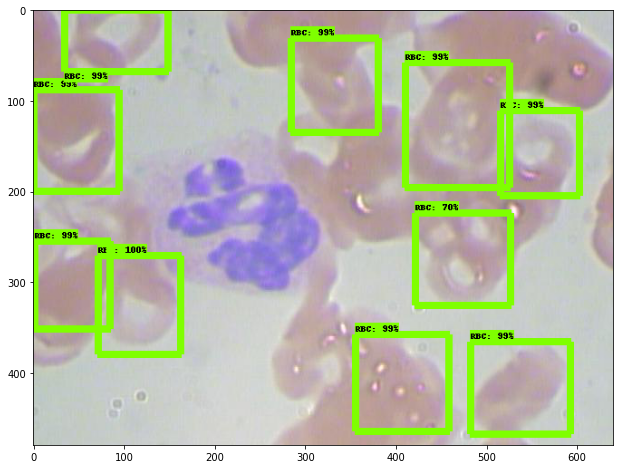

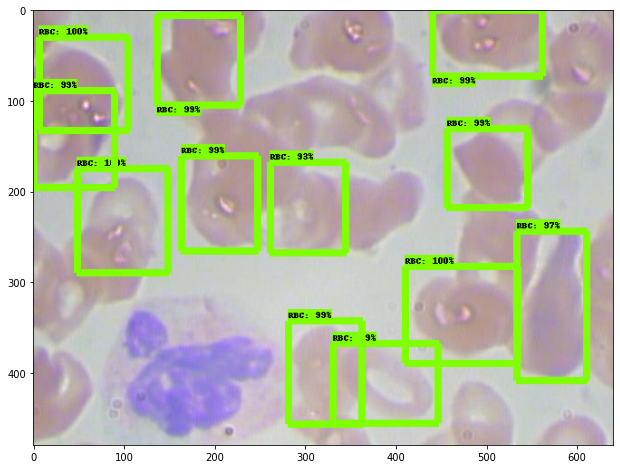

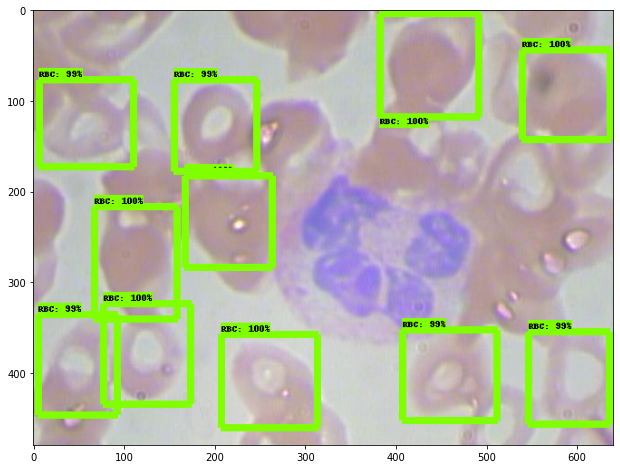

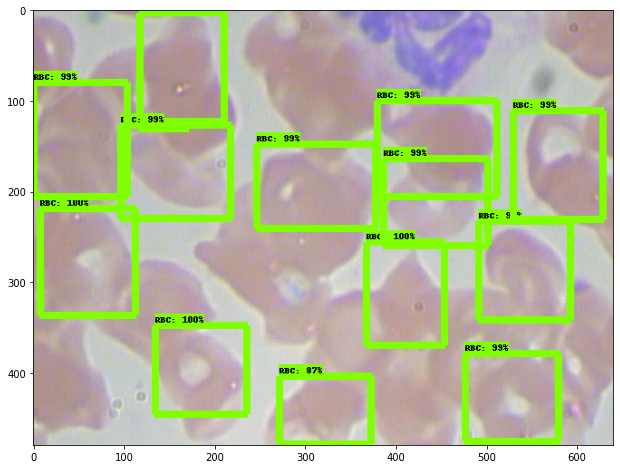

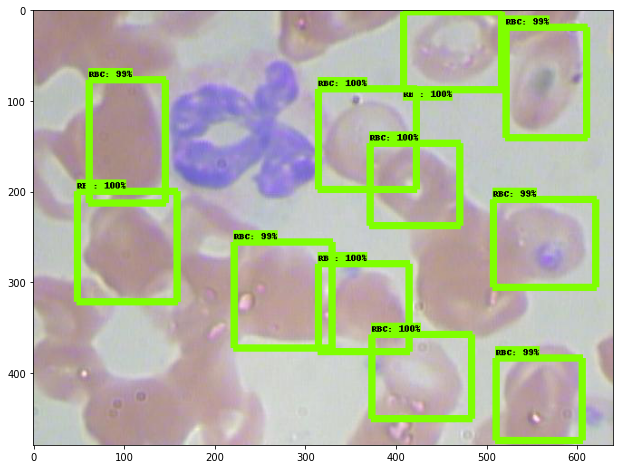

In [33]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)